In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import obnb
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from obnb.dataset import OpenBiomedNetBench
from tqdm import tqdm

sns.set()
BARFMT = "{l_bar}{bar:40}{r_bar}{bar:-40b}"
VERSION = obnb.__data_version__

In [2]:
# Load selected results
selected_models = {
    "GCN",
    "GAT",
    "GIN",
    "SAGE",
    "GatedGCN",
    "GCN+BoT",
    "GAT+BoT",
    "GIN+BoT",
    "SAGE+BoT",
    "GatedGC+BoTN",
    "LogReg+Adj",
    "LogReg+Node2vec",
    "LabelProp",
}

score_df = (
    pd.read_csv("../results/main.csv.gz")
    .query("split == 'test' & score_type == 'APOP'")
    .groupby(["name", "task_id"], as_index=False)
    .mean(numeric_only=True)
)

score_df = score_df.loc[~score_df["name"].str.contains("-BoT")]
score_df[["network", "label", "model"]] = score_df["name"].str.split("-", expand=True)
score_df = score_df.loc[score_df["model"].isin(selected_models)]
score_df = score_df.drop(columns="name")
score_df

,task_id,score_value,network,label,model
0,MONDO:0000066,3.720390,BioGRID,DISEASES,GAT
1,MONDO:0000226,0.832281,BioGRID,DISEASES,GAT
2,MONDO:0000425,0.080663,BioGRID,DISEASES,GAT
3,MONDO:0000426,0.195115,BioGRID,DISEASES,GAT
4,MONDO:0000462,0.246171,BioGRID,DISEASES,GAT
...,...,...,...,...,...
258566,GO:0072659,1.194745,STRING,GOBP,SAGE
258567,GO:0090090,2.358861,STRING,GOBP,SAGE
258568,GO:0090263,1.592249,STRING,GOBP,SAGE
258569,GO:0098609,2.771737,STRING,GOBP,SAGE


In [3]:
# Compute homophily measures
# ----------------------
networks = [
    "BioGRID",
    "HumanNet",
    "ComPPIHumanInt",
]
labels = ["DISEASES", "DisGeNET", "GOBP"]
metric = "APOP"

eval_on_test_only = False
# ----------------------

stats_dict = {}
for network, label in tqdm(
    itertools.product(networks, labels),
    total=len(networks) * len(labels),
    bar_format=BARFMT,
):
    dataset = OpenBiomedNetBench(
        "../datasets",
        version=VERSION,
        graph_name=network,
        label_name=label,
        log_level="ERROR",
    )
    
    adj = dataset.graph.to_dense_graph().mat
    y = dataset.label.get_y(dataset.graph.node_ids)
    
    # Propagation matrix
    P = adj / adj.sum(1, keepdims=True)
    
    if eval_on_test_only:  # if set to True, might need to use log1p instead
        mask = dataset.masks["test"].ravel()
        y_masked = y.copy()
        y_masked[mask] = 0
        z = P @ y 
    else:
        mask = y.any(1)
        z = P @ y

    h_pos = (z[mask] * y[mask]).sum(0) / y[mask].sum(0)
    h_neg = (z[mask] * (1 - y[mask])).sum(0) / (1 - y[mask]).sum(0)
    h = np.log2(h_pos / h_neg)  # corrected homophily ratio
    
    # Register results
    stats_dict[(network, label)] = {}
    stats_dict[(network, label)]["task_ids"] = dataset.label.label_ids
    stats_dict[(network, label)]["h_pos"] = h_pos
    stats_dict[(network, label)]["h_neg"] = h_neg
    stats_dict[(network, label)]["h"] = h
    
    # Release memory
    del dataset, adj,y, P, z, mask, h_pos, h_neg, h

100%|████████████████████████████████████████| 9/9 [02:32<00:00, 16.90s/it]                                                                                                 


In [4]:
# Combine scores and stats into a dataframe
stats_dfs = []
for (network, label), stats in stats_dict.items():
    stats_dfs.append(pd.DataFrame(stats))
    stats_dfs[-1] = stats_dfs[-1].rename(columns={"task_ids": "task_id"})
    stats_dfs[-1]["network"] = network
    stats_dfs[-1]["label"] = label
stats_df = pd.concat(stats_dfs).set_index(["network", "label", "task_id"])

result_df = stats_df.join(
    score_df.pivot_table("score_value", ["network", "label", "task_id"], "model"),
    how="inner",
)
result_df["dataset"] = (
    result_df.index.get_level_values("network")
    + "-"
    + result_df.index.get_level_values("label")
)
result_df

h_pos     h_neg         h       GAT  \
network        label    task_id                                                 
BioGRID        DISEASES MONDO:0002245  0.027254  0.004280  2.670672  0.362529   
                        MONDO:0021129  0.032196  0.003429  3.231227  0.760938   
                        MONDO:0000066  0.132570  0.003759  5.140290  3.720390   
                        MONDO:0005039  0.082024  0.065575  0.322898  0.397199   
                        MONDO:0002320  0.037584  0.028226  0.413093  0.184856   
...                                         ...       ...       ...       ...   
ComPPIHumanInt GOBP     GO:0007160     0.073555  0.005640  3.704932  3.409341   
                        GO:0001227     0.050808  0.013989  1.860717  1.808653   
                        GO:0003714     0.059947  0.017125  1.807590  2.345194   
                        GO:0007601     0.090177  0.003045  4.888269  2.220402   
                        GO:0030512     0.090619  0.008898  3.348213  2.324973   

                                        GAT+BoT       GCN   GCN+BoT       GIN  \
network        label    task_id                                                 
BioGRID        DISEASES MONDO:0002245  4.023287  1.158648  3.621089 -0.313660   
                        MONDO:0021129  2.560047  1.569610  2.756721  0.649019   
                        MONDO:0000066  4.715348  3.961923  4.741442  4.233136   
                        MONDO:0005039  0.925279  0.605333  0.640005  0.619836   
                        MONDO:0002320  0.100353  0.030720  0.167195  0.344641   
...                                         ...       ...       ...       ...   
ComPPIHumanInt GOBP     GO:0007160     4.908465  1.844678  4.860024  1.322452   
                        GO:0001227     2.407801  1.771008  2.388738  1.907032   
                        GO:0003714     4.405141  2.937333  4.201909  2.383785   
                        GO:0007601     3.800103  2.870393  3.854237  0.521167   
                        GO:0030512     3.559023  3.015172  3.808914  2.897841   

                                        GIN+BoT  GatedGCN  LabelProp  \
network        label    task_id                                        
BioGRID        DISEASES MONDO:0002245  1.395249  0.314782   0.916502   
                        MONDO:0021129  3.200080  0.774289   3.420498   
                        MONDO:0000066  4.627248  4.449300   4.479505   
                        MONDO:0005039  0.772011  0.710405   0.331216   
                        MONDO:0002320  0.220043  0.250751   0.308810   
...                                         ...       ...        ...   
ComPPIHumanInt GOBP     GO:0007160     4.058941  2.823900   2.102409   
                        GO:0001227     2.323943  1.547664   1.403381   
                        GO:0003714     2.767123  3.082097   2.409256   
                        GO:0007601     3.616011  1.092315   2.822923   
                        GO:0030512     3.695648  1.967034   3.569138   

                                       LogReg+Adj  LogReg+Node2vec      SAGE  \
network        label    task_id                                                
BioGRID        DISEASES MONDO:0002245    0.815311        -0.051654  0.683662   
                        MONDO:0021129    2.330032         2.103323  0.455833   
                        MONDO:0000066    4.614678         4.789705  4.337318   
                        MONDO:0005039    1.055850         0.737240  0.342792   
                        MONDO:0002320    0.111423         0.299641  0.166195   
...                                           ...              ...       ...   
ComPPIHumanInt GOBP     GO:0007160       2.796447         3.078492  1.102178   
                        GO:0001227       2.268152         2.454871  2.058772   
                        GO:0003714       5.026521         3.463894  2.660889   
                        GO:0007601       0.866572         0.941990  1.504601   
                        GO:0030512   

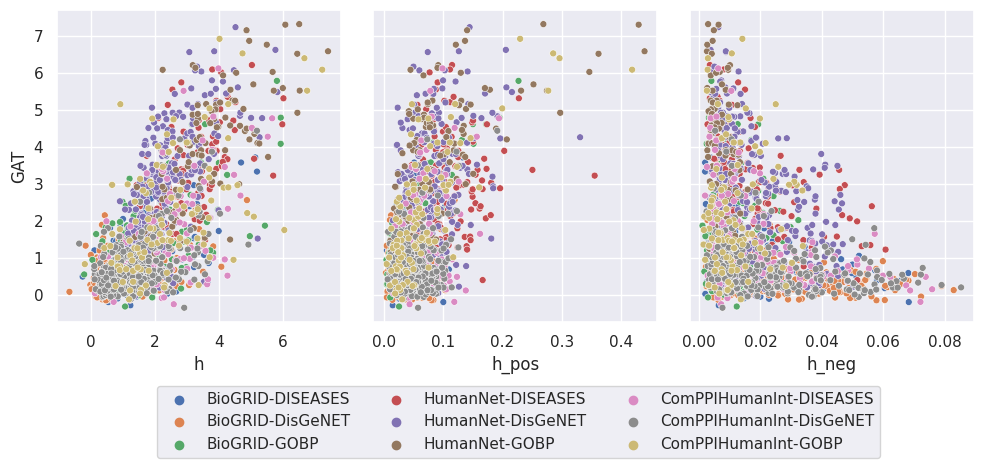

In [5]:
# ----------------
model = "GAT"
# ----------------

fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
for i, (ax, stat_type) in enumerate(zip(axes, ["h", "h_pos", "h_neg"])):
    sns.scatterplot(
        data=result_df,
        x=stat_type,
        y=model,
        hue="dataset",
        ax=ax,
        s=25,
    )
    ax.get_legend().remove()

plt.tight_layout()
plt.legend(loc="center", bbox_to_anchor=(-0.6, -0.32), ncols=3)
plt.show()

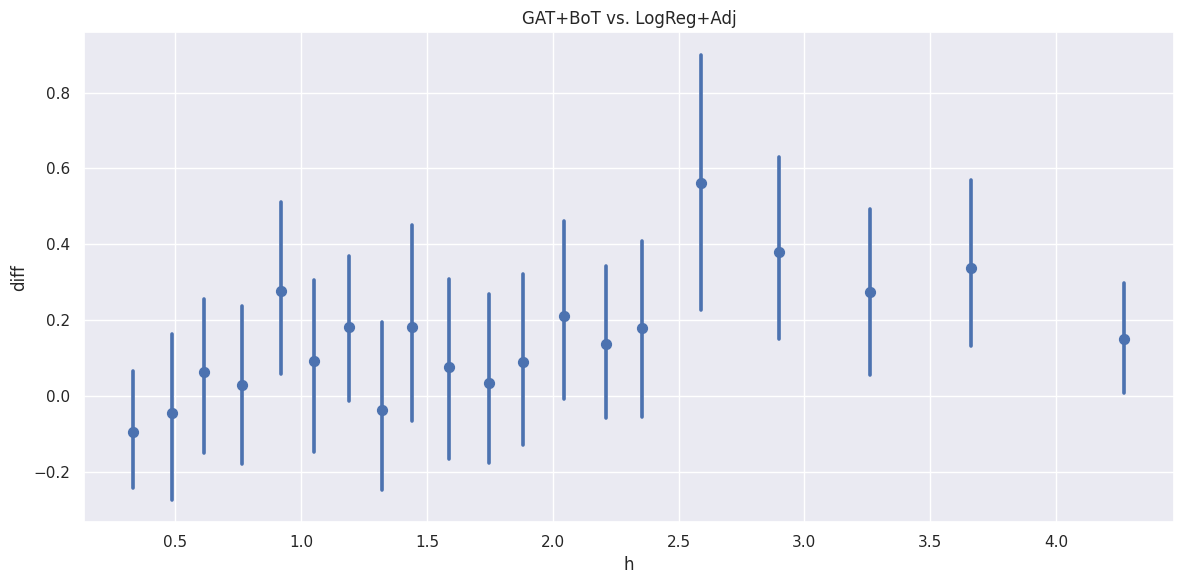

In [6]:
# Performance difference between two models for a particular task as a function of homohpily
# ------------------------
model1 = "GAT+BoT"
model2 = "LogReg+Adj"

plot_scatter = False
# -----------------

datasets = list(itertools.product(networks, labels))

plt.figure(figsize=(12, 6))
diff_df = result_df.loc[:, ["dataset", "h", model1, model2]]
diff_df["diff"] = diff_df[model1] - diff_df[model2]

if plot_scatter:
    sns.scatterplot(
        data=diff_df,
        x="h",
        y="diff",
        hue="dataset",
        s=20,
    )
    plt.legend(loc="right", bbox_to_anchor=(1.4, 0.5))
else:
    sns.regplot(
        data=diff_df,
        x="h",
        y="diff",
        x_bins=20,
        fit_reg=False,
    )

plt.title(f"{model1} vs. {model2}")
plt.tight_layout()
plt.show()

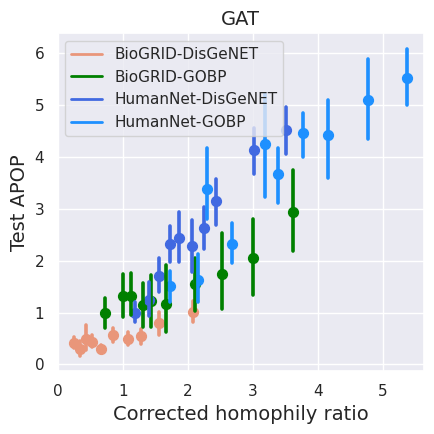

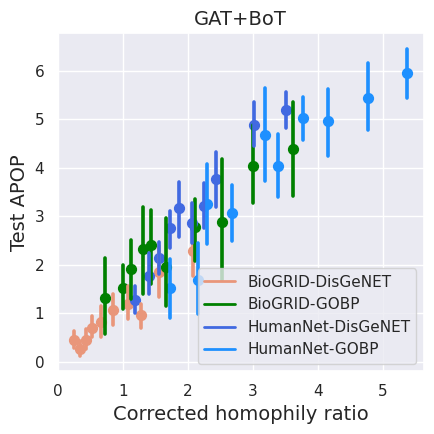

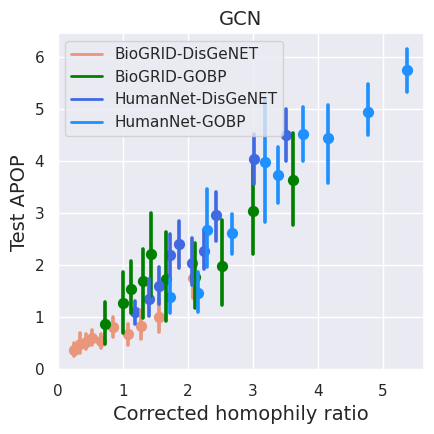

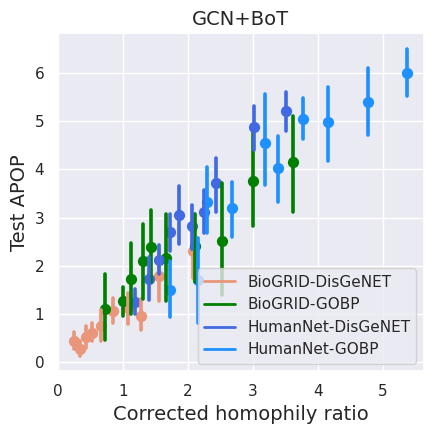

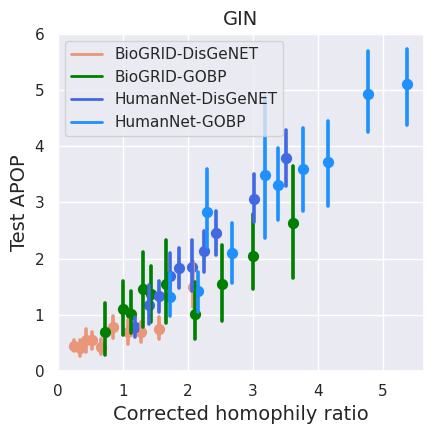

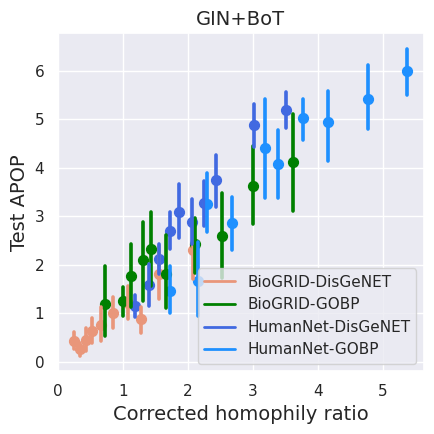

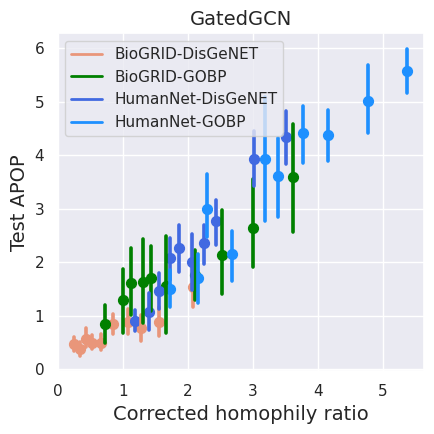

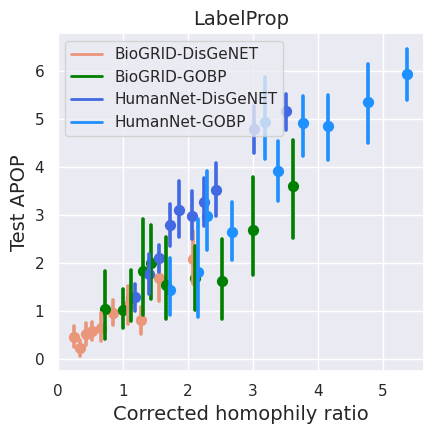

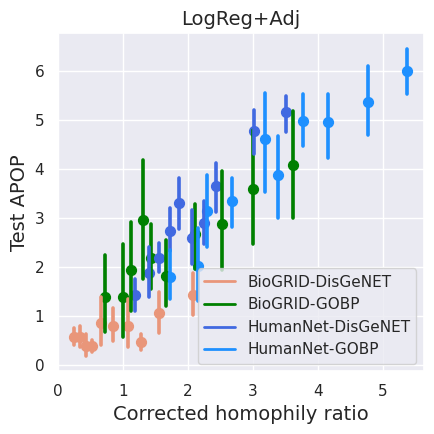

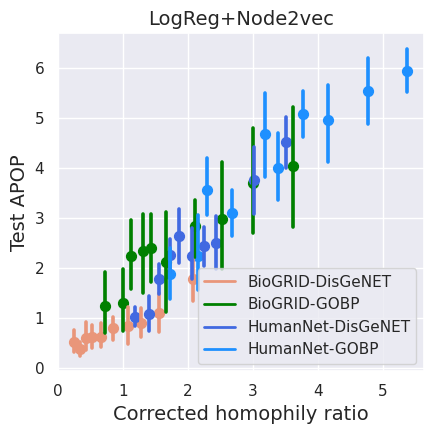

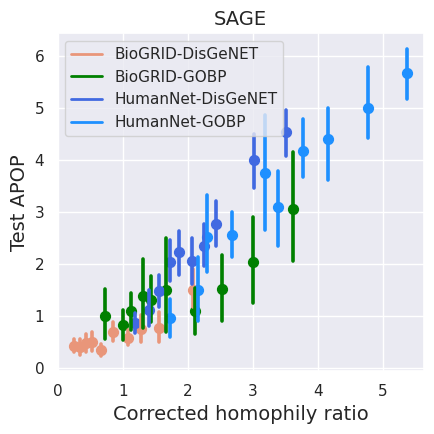

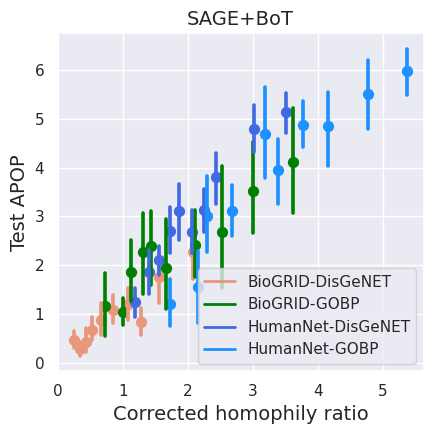

In [9]:
# -----------------
stat_type = "h"  # ["h", "h_pos", "h_neg"]
stat_type_name_dict = {
    "h": "Corrected homophily ratio",
    "h_pos": "Homophily ratio",
    "h_neg": "Negative homophily ratio",
}

color_dict = {
    ("BioGRID", "DisGeNET"): "darksalmon",
    ("BioGRID", "GOBP"): "green",
    ("HumanNet", "DisGeNET"): "royalblue",
    ("HumanNet", "GOBP"): "dodgerblue",
}

plot_scatter = False
# -----------------

# Make shared legends
legend_lines, legend_names = [], []
for (network, label), color in color_dict.items():
    legend_names.append(f"{network}-{label}")
    legend_lines.append(Line2D([0], [0], color=color, lw=2))

# Generate plots
for model in score_df["model"].unique():
    plt.figure(figsize=(4.5, 4.5))
    for (network, label), color in color_dict.items():
        if plot_scatter:
            sns.scatterplot(
                data=result_df.query("network == @network & label == @label"),
                x=stat_type,
                y=model,
                color=color,
            )
        else:
            sns.regplot(
                data=result_df.query("network == @network & label == @label"),
                x=stat_type,
                y=model,
                x_bins=10,
                fit_reg=False,
                color=color,
            )

    plt.title(model, fontsize=14)
    plt.legend(legend_lines, legend_names)
    plt.xlabel(stat_type_name_dict[stat_type], fontsize=14)
    plt.ylabel(f"Test {metric}", fontsize=14)
    plt.tight_layout()
    # plt.savefig(f"perf_analysis_{model}_{stat_type}.pdf", bbox_inches="tight")  # uncomment to save
    plt.show()